This script is to map the veg data w weather data

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
files = os.listdir('../Weather_Data/')
files

['dead_fuel_moisture_1000hr.2001.2023.CA.nc',
 'dead_fuel_moisture_100hr.2001.2023.CA.nc',
 'max_air_temperature.2001.2023.CA-008.nc',
 'max_relative_humidity.2001.2023.CA.nc',
 'min_air_temperature.2001.2023.CA-009.nc',
 'min_relative_humidity.2001.2023.CA.nc',
 'Palmer_Drought_Severity_Index.2001.2023.CA.nc',
 'precipitation_amount.2001.2023.CA.nc',
 'specific_humidity.2001.2023.CA.nc',
 'surface_downwelling_shortwave_flux.2001.2023.CA.nc',
 'wind_from_direction.2001.2023.CA.nc',
 'wind_speed.2001.2023.CA.nc']

In [7]:
data_dir = '../Weather_Data/'
# Load the first dataset to use as a reference
reference_ds = xr.open_dataset(os.path.join(data_dir, files[-1]))

In [8]:
print(f"Dimensions: {reference_ds.dims}")
print(f"Coordinates: {reference_ds.coords}")
print(f"Data variables: {reference_ds.data_vars}")

Dimensions: Frozen({'day': 8400, 'lon': 259, 'lat': 240})
Coordinates: Coordinates:
  * day      (day) datetime64[ns] 2001-01-01 2001-01-02 ... 2023-12-31
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -114.1 -114.1 -114.0
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.15 32.11 32.07 32.03
Data variables: Data variables:
    wind_speed  (day, lat, lon) float32 ...


In [39]:
# Extract lon and lat coordinates
lon = reference_ds.coords['lon'].values
lat = reference_ds.coords['lat'].values

# Create a DataFrame with all combinations of lon and lat
lon_lat_combinations = pd.DataFrame([(lo, la) for lo in lon for la in lat], columns=['lon', 'lat'])

In [40]:
lon_lat_combinations.head()

,lon,lat
0,-124.766667,41.983333
1,-124.766667,41.941667
2,-124.766667,41.900000
3,-124.766667,41.858333
4,-124.766667,41.816667


In [41]:
lon_lat_combinations.shape[0] == 259*240 # 62,160

True

In [5]:
# check vegetation_dat from Vegetation_Data/
vegetation_dat = xr.open_dataset('../Vegetation_Data/vegetation.nc')

In [14]:
file_path = '../Vegetation_Data/veg_mapping.csv'
# read the csv file
veg_mapping = pd.read_csv(file_path, header=None)
cols = ['type', 'veg_type']
# rename the columns
veg_mapping.columns = cols

In [6]:
vegetation_dat

<xarray.Dataset>
Dimensions:  (lon: 205, lat: 230)
Coordinates:
  * lon      (lon) float64 -124.4 -124.4 -124.3 -124.3 ... -116.0 -116.0 -115.9
  * lat      (lat) float64 42.08 42.04 41.99 41.95 ... 32.66 32.62 32.58 32.54
Data variables:
    type     (lat, lon) float32 ...
Attributes:
    Conventions:      CF-1.0
    Source_Software:  Esri ArcGIS

In [7]:
# transform vegetation_dat from xarray to panda
vegetation_dat = vegetation_dat.to_dataframe().reset_index()

In [8]:
# check % of NA in column type
vegetation_dat['type'].isna().sum() / vegetation_dat.shape[0]

0.6243054082714741

In [9]:
# drop rows with NA in column type
vegetation_dat = vegetation_dat.dropna(subset=['type'])

In [10]:
vegetation_dat.shape

(17714, 3)

In [16]:
veg_mapping.dtypes

type         int64
veg_type    object
dtype: object

In [12]:
vegetation_dat.dtypes

lon     float64
lat     float64
type    float32
dtype: object

In [36]:
veg_mapping

,type,veg_type
0,1,Agriculture - low
1,2,Agriculture - rarely
2,3,Barren - rarely
3,4,Native Chapparal - archetypical
4,5,Native Chapparal - fire
5,6,Native Coastal Sage Scrub - archetypical
6,7,Native Coastal Sage Scrub - fire
7,8,Native Coastal Sage Scrub - mesic
8,9,Native Conifer Alpine - fire
9,10,Native Conifer Alpine - low


In [17]:
# merge vegetation_dat with veg_mapping, on 'type'
vegetation_dat = vegetation_dat.merge(veg_mapping, on='type')
vegetation_dat.shape

(17714, 4)

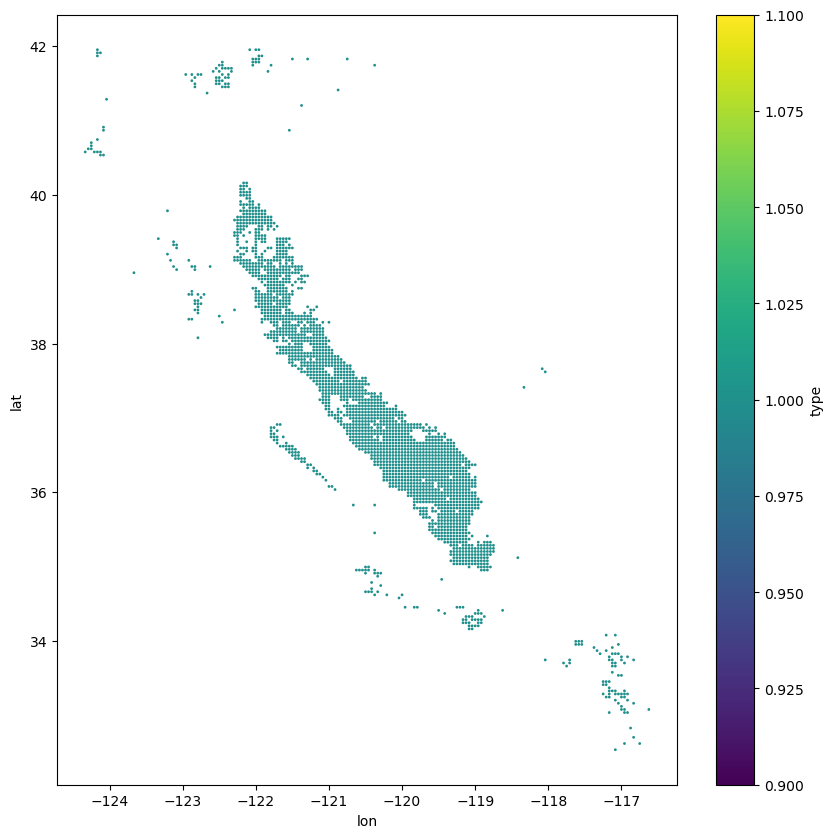

In [26]:
vegetation_dat[vegetation_dat['type'] == 1].plot(kind='scatter', x='lon', y='lat', c='type', cmap='viridis', s=1, figsize=(10, 10))
plt.show()

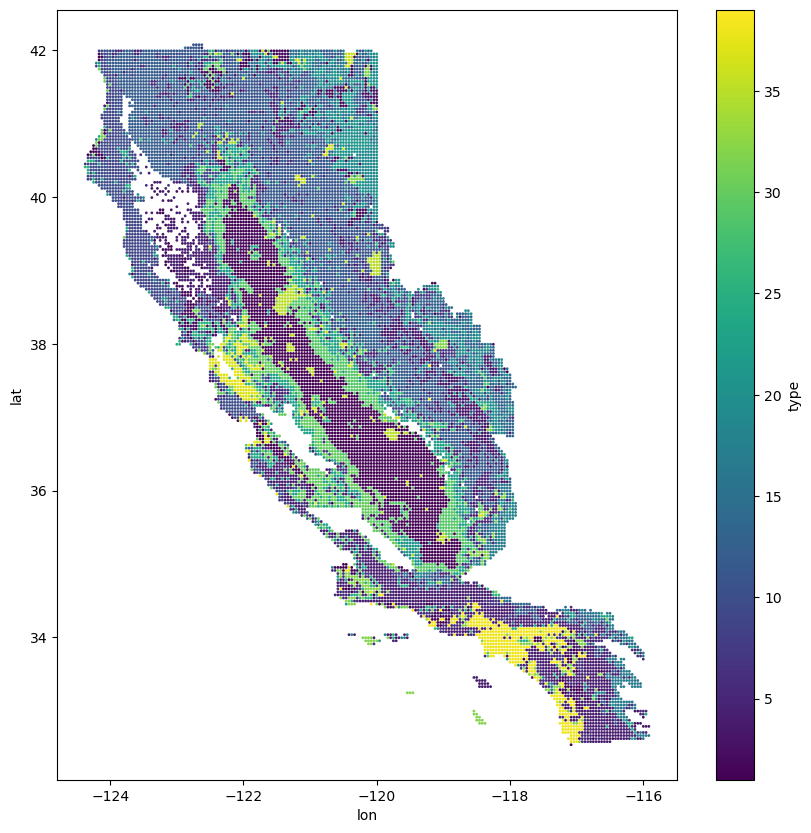

In [22]:
# plot the vegetation_dat
vegetation_dat.plot(kind='scatter', x='lon', y='lat', c='type', cmap='viridis', s=1, figsize=(10, 10))
plt.show()

In [47]:
# example to use geodesic()
from geopy.distance import geodesic

# Define the coordinates
coords_1 = (40.452058, -124.374975)
coords_2 = (40.41039, -124.374975)

# Calculate the distance
distance = geodesic(coords_1, coords_2).km

# Print the distance
print(f"Distance: {distance} km")

Distance: 4.626936837923472 km


In [45]:
lon_lat_combinations.shape

(62160, 4)

In [46]:
vegetation_dat.shape

(17714, 3)

In [63]:
from scipy.spatial import cKDTree

# Create a KDTree for the vegetation_dat coordinates
tree = cKDTree(vegetation_dat[['lat', 'lon']].values)

# Query the nearest neighbors for each point in lon_lat_combinations
approx_distances, indices = tree.query(lon_lat_combinations[['lat', 'lon']].values, k=1)

In [65]:
#  check the range pf distances
approx_distances.min(), approx_distances.max()

(0.01966184242954689, 5.7982869004113535)

In [64]:
# Calculate the exact geodesic distances
exact_distances = []
for i, idx in enumerate(indices):
    coords_1 = (lon_lat_combinations.iloc[i]['lat'], lon_lat_combinations.iloc[i]['lon'])
    coords_2 = (vegetation_dat.iloc[idx]['lat'], vegetation_dat.iloc[idx]['lon'])
    distance = geodesic(coords_1, coords_2).km
    exact_distances.append(distance)

# Convert exact_distances to a numpy array
exact_distances = np.array(exact_distances)

In [66]:
#  check the range pf distances
exact_distances.min(), exact_distances.max()

(1.8014835361283597, 555.3446232270336)

In [106]:
# Filter out distances greater than 2 km
mask = exact_distances < 2
# Assign the nearest type and distance to lon_lat_combinations
lon_lat_combinations['type'] = np.where(mask, vegetation_dat.iloc[indices]['type'].values, np.nan)
lon_lat_combinations['distance'] = np.where(mask, exact_distances, np.nan)

In [107]:
# check the % of NA in lon_lat_combinations
lon_lat_combinations['type'].isna().sum() / lon_lat_combinations.shape[0]

0.7152027027027027

Plot 2 maps side by side to check the veg data before and after mapping w weather data
- Left: after mapping
- Right: before mapping

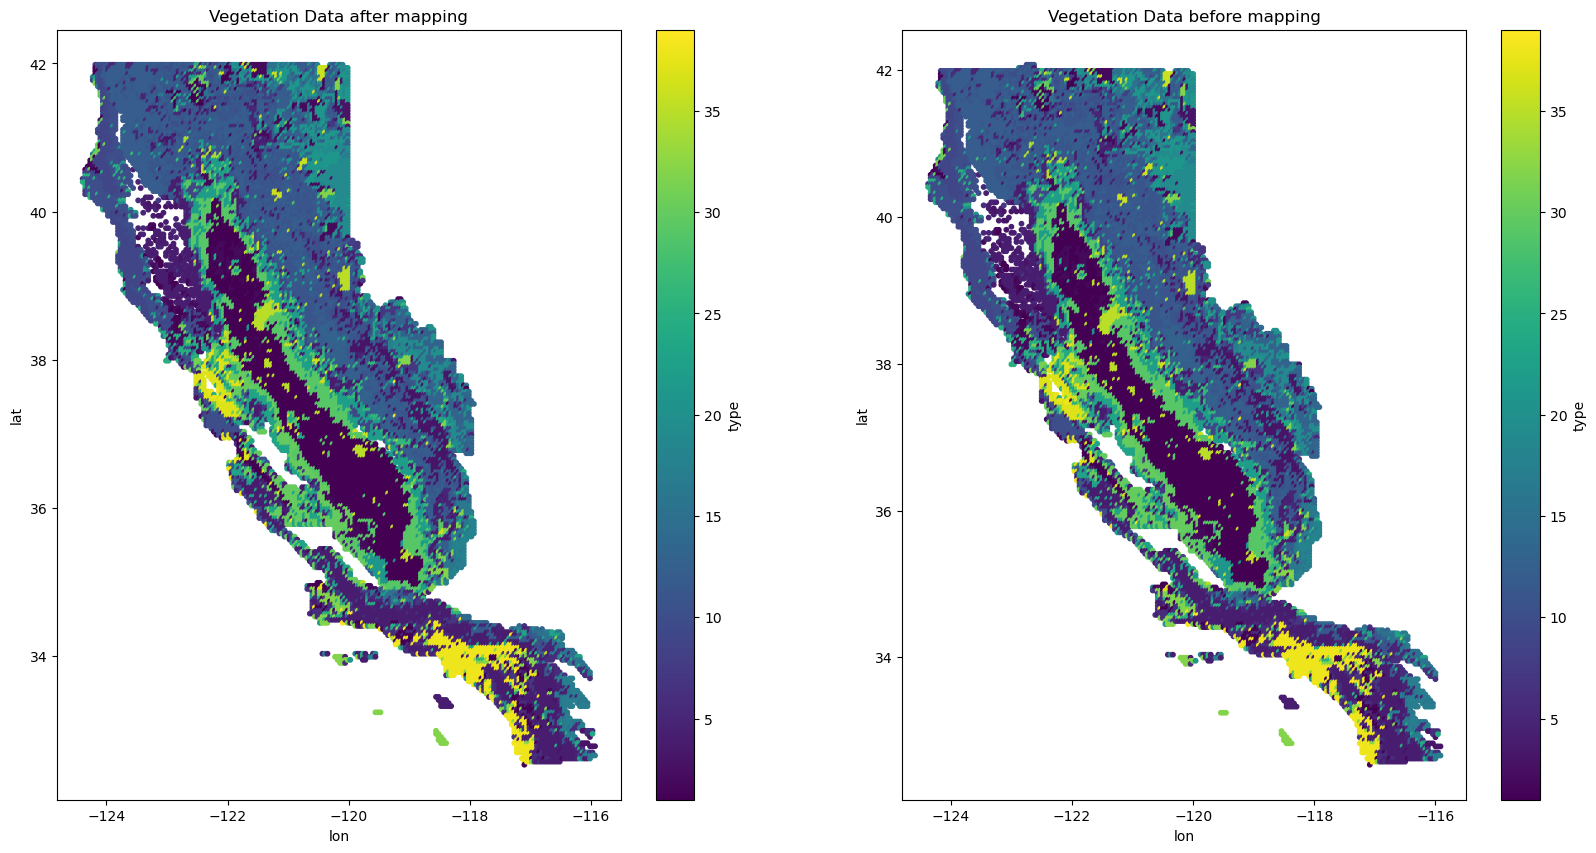

In [109]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Plot lon_lat_combinations on the first subplot
lon_lat_combinations.plot(kind='scatter', x='lon', y='lat', c='type', cmap='viridis', s=10, ax=axes[0])
axes[0].set_title('Vegetation Data after mapping')

# Plot vegetation_dat on the second subplot
vegetation_dat.plot(kind='scatter', x='lon', y='lat', c='type', cmap='viridis', s=10, ax=axes[1])
axes[1].set_title('Vegetation Data before mapping')

# Show the plots
plt.show()

In [115]:
# Remove rows with NaN values in the 'type' column
lon_lat_combinations_cleaned = lon_lat_combinations.dropna(subset=['type'])

# Print final state
print("DataFrame after removing rows with NaN in 'type' column:")
print(f"Final number of rows: {len(lon_lat_combinations_cleaned)}\n")

# Print the number of rows removed
rows_removed = len(lon_lat_combinations) - len(lon_lat_combinations_cleaned)
print(f"Number of rows removed: {rows_removed}")

DataFrame after removing rows with NaN in 'type' column:
Final number of rows: 17703

Number of rows removed: 44457


In [117]:
# save data to parquet file
lon_lat_combinations_cleaned.to_parquet('../Clean_Data/lon_lat_pair_weather_match_veg.parquet')